# SFTGAN

Superresolution paper from 2018: "Recovering Realistic Texture in Image Super-resolution by Deep Spatial Feature Transform"

![SFTGAN model](https://raw.githubusercontent.com/xinntao/SFTGAN/master/figures/network_structure.png)

Check out https://github.com/xinntao/SFTGAN and the blog https://kingdomakrillic.tumblr.com/post/178254875891/i-figured-out-how-to-get-esrgan-and-sftgan

In [1]:
# This is for downloading model weights (and possibly your own data) from google drive:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
!git clone https://github.com/xinntao/SFTGAN.git

Cloning into 'SFTGAN'...
remote: Enumerating objects: 155, done.
remote: Total 155 (delta 0), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (155/155), 11.40 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [3]:
%cd SFTGAN

/content/SFTGAN


In [4]:
!ls

data  figures  pretrained_models  pytorch_test	README.md  torch_test


In [5]:
file_id = '1vuceMHbu5RemKpx8ARKfCYd86xXdxB2C'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('pretrained_models/SFTGAN_torch.pth')

file_id = '1xxj9DQnsHQYqBNdmXePrL6wJzZfzgsPX'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('pretrained_models/SFTGAN_noBN_OST_bg.pth')

file_id = '1Xx00gG0Z-i9Kkq36ISfbl0jcqQjowW3w'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('pretrained_models/segmentation_OST_bic.pth')

In [6]:
!ls -luah pretrained_models
# ps: strangely the segmentation model is the largest one in this repo ...

total 213M
drwxr-xr-x 2 root root 4.0K Jul 12 11:55 .
drwxr-xr-x 8 root root 4.0K Jul 12 11:55 ..
-rw-r--r-- 1 root root  681 Jul 12 11:55 README.md
-rw-r--r-- 1 root root 200M Jul 12 11:55 segmentation_OST_bic.pth
-rw-r--r-- 1 root root 7.1M Jul 12 11:55 SFTGAN_noBN_OST_bg.pth
-rw-r--r-- 1 root root 6.2M Jul 12 11:55 SFTGAN_torch.pth


In [7]:
%cd pytorch_test

/content/SFTGAN/pytorch_test


## 0.) (optional) Download your own data here:

In [8]:
file_id = '1jpZ4HXc7UJ_QfK5G2ZzpUaXQXECqEubG'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('../data/samples_gens.zip')

In [9]:
!unzip ../data/samples_gens.zip

Archive:  ../data/samples_gens.zip
   creating: samplesOfGenerations_gensAlsoIn1024/
   creating: samplesOfGenerations_gensAlsoIn1024/genColor/
  inflating: samplesOfGenerations_gensAlsoIn1024/genColor/image_0002.jpg  
  inflating: samplesOfGenerations_gensAlsoIn1024/genColor/image_1475.jpg  
  inflating: samplesOfGenerations_gensAlsoIn1024/genColor/image_2614.jpg  
  inflating: samplesOfGenerations_gensAlsoIn1024/genColor/image_2640.jpg  
  inflating: samplesOfGenerations_gensAlsoIn1024/genColor/image_2662.jpg  
  inflating: samplesOfGenerations_gensAlsoIn1024/genColor/image_2794.jpg  
   creating: samplesOfGenerations_gensAlsoIn1024/genGray/
  inflating: samplesOfGenerations_gensAlsoIn1024/genGray/image_0037.jpg  
  inflating: samplesOfGenerations_gensAlsoIn1024/genGray/image_0052.jpg  
  inflating: samplesOfGenerations_gensAlsoIn1024/genGray/image_0321.jpg  
  inflating: samplesOfGenerations_gensAlsoIn1024/genGray/image_0534.jpg  
  inflating: samplesOfGenerations_gensAlsoIn1024/gen

In [11]:
!mkdir ../data/myimages
!mv samplesOfGenerations_gensAlsoIn1024/genGray/* ../data/myimages # tested and also works with black and white / grayscale images!

## 1.) First we need to use the provided segmentation model to generate segmentation maps (labels of areas of the original image)

In [ ]:
# Setup the folder name:
test_img_folder_name = 'samples'  # < put your own image folder name here (points to "../data/<test_img_folder_name>")

# Select a model for the super resolution step:
# (see the original repo for the differences)
superres_model_path = '../pretrained_models/SFTGAN_torch.pth'  # torch version
# superres_model_path = '../pretrained_models/SFTGAN_noBN_OST_bg.pth'  # pytorch version

In [17]:
'''
Segmentation codes for generating segmentation probability maps for SFTGAN
'''

import os
import glob
import numpy as np
import cv2

import torch
import torchvision.utils

import architectures as arch
import util

# options
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device('cuda')  # if you want to run on CPU, change 'cuda' -> 'cpu'
# device = torch.device('cpu')

# make dirs
test_img_folder = '../data/' + test_img_folder_name  # HR images
save_prob_path = '../data/' + test_img_folder_name + '_segprob'  # probability maps
save_byteimg_path = '../data/' + test_img_folder_name + '_byteimg'  # segmentation annotations
save_colorimg_path = '../data/' + test_img_folder_name + '_colorimg'  # segmentaion color results
util.mkdirs([save_prob_path, save_byteimg_path, save_colorimg_path])

# load model
seg_model = arch.OutdoorSceneSeg()
model_path = '../pretrained_models/segmentation_OST_bic.pth'
seg_model.load_state_dict(torch.load(model_path), strict=True)
seg_model.eval()
seg_model = seg_model.to(device)

# look_up table, RGB, for coloring the segmentation results
lookup_table = torch.from_numpy(
    np.array([
        [153, 153, 153],  # 0, background
        [0, 255, 255],    # 1, sky
        [109, 158, 235],  # 2, water
        [183, 225, 205],  # 3, grass
        [153, 0, 255],    # 4, mountain
        [17, 85, 204],    # 5, building
        [106, 168, 79],   # 6, plant
        [224, 102, 102],  # 7, animal
        [255, 255, 255],  # 8/255, void
    ])).float()
lookup_table /= 255

print('Testing segmentation probability maps ...')

for idx, path in enumerate(glob.glob(test_img_folder + '/*')):
    imgname = os.path.basename(path)
    basename = os.path.splitext(imgname)[0]
    print(idx + 1, basename)
    # read image
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = util.modcrop(img, 8)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
        
    print(img.shape) # w,h,3 <- 1
    stacked_img = np.stack((img,)*3, axis=2)
    stacked_img = stacked_img[:,:,:,0]
    print(stacked_img.shape) # w,h,3 <- 1
    img = stacked_img

        
    img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()

    # MATLAB imresize
    # You can use the MATLAB to generate LR images first for faster imresize operation
    img_LR = util.imresize(img / 255, 1 / 4, antialiasing=True)
    img = util.imresize(img_LR, 4, antialiasing=True) * 255

    img[0] -= 103.939
    img[1] -= 116.779
    img[2] -= 123.68
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        output = seg_model(img).detach().float().cpu().squeeze()
    # save segmentation probability maps
    torch.save(output, os.path.join(save_prob_path, basename + '_bic.pth'))  # 8xHxW
    # save segmentation byte images (annotations)
    _, argmax = torch.max(output, 0)
    argmax = argmax.squeeze().byte()
    cv2.imwrite(os.path.join(save_byteimg_path, basename + '.png'), argmax.numpy())
    # save segmentation colorful results
    im_h, im_w = argmax.size()
    color = torch.FloatTensor(3, im_h, im_w).fill_(0)  # black
    for i in range(8):
        mask = torch.eq(argmax, i)
        color.select(0, 0).masked_fill_(mask, lookup_table[i][0])  # R
        color.select(0, 1).masked_fill_(mask, lookup_table[i][1])  # G
        color.select(0, 2).masked_fill_(mask, lookup_table[i][2])  # B
    # void
    mask = torch.eq(argmax, 255)
    color.select(0, 0).masked_fill_(mask, lookup_table[8][0])  # R
    color.select(0, 1).masked_fill_(mask, lookup_table[8][1])  # G
    color.select(0, 2).masked_fill_(mask, lookup_table[8][2])  # B
    torchvision.utils.save_image(
        color, os.path.join(save_colorimg_path, basename + '.png'), padding=0, normalize=False)

Testing segmentation probability maps ...
1 OST_013
(480, 640, 3)
(480, 640, 3)
2 OST_215
(536, 720, 3)
(536, 720, 3)


## 2.) Then we run the superresolution network:

In [24]:
'''
Codes for testing SFTGAN
'''

import os
import glob
import numpy as np
import cv2
import torch
import util
import architectures as arch

# options
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
model_path = superres_model_path

device = torch.device('cuda')  # if you want to run on CPU, change 'cuda' -> 'cpu'
# device = torch.device('cpu')

test_img_folder = '../data/' + test_img_folder_name  # HR images
test_prob_path = '../data/' + test_img_folder_name + '_segprob'  # probability maps
save_result_path = '../data/' + test_img_folder_name + '_result'  # results
util.mkdirs([save_result_path])

if 'torch' in model_path:  # torch version
    model = arch.SFT_Net_torch()
else:  # pytorch version
    model = arch.SFT_Net()
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)

print('Testing SFTGAN ...')

for idx, path in enumerate(glob.glob(test_img_folder + '/*')):
    imgname = os.path.basename(path)
    basename = os.path.splitext(imgname)[0]
    print(idx + 1, basename)
    # read image
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = util.modcrop(img, 8)
    img = img * 1.0 / 255
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
        
    ### NOTE: for black and white images uncomment this:
    """
    print(img.shape) # w,h,3 <- 1
    stacked_img = np.stack((img,)*3, axis=2)
    stacked_img = stacked_img[:,:,:,0]
    print(stacked_img.shape) # w,h,3 <- 1
    img = stacked_img
    """
    
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    # MATLAB imresize
    # You can use the MATLAB to generate LR images first for faster imresize operation
    img_LR = util.imresize(img, 1 / 4, antialiasing=True)
    img_LR = img_LR.unsqueeze(0)
    img_LR = img_LR.to(device)

    # read segmentation probability maps
    seg = torch.load(os.path.join(test_prob_path, basename + '_bic.pth'))
    seg = seg.unsqueeze(0)
    # change probability
    # seg.fill_(0)
    # seg[:,5].fill_(1)
    seg = seg.to(device)
    with torch.no_grad():
        output = model((img_LR, seg)).data.float().cpu().squeeze()
    output = util.tensor2img(output)
    util.save_img(output, os.path.join(save_result_path, basename + '_rlt.png'))

Testing SFTGAN ...
1 OST_013
2 OST_215


In [19]:
!zip -r superres.zip ../data/samples_result

  adding: ../data/samples_result/ (stored 0%)
  adding: ../data/samples_result/OST_215_rlt.png (deflated 1%)
  adding: ../data/samples_result/OST_013_rlt.png (deflated 0%)


In [15]:
from google.colab import files

files.download('superres.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3.) Results

### Original resolution:

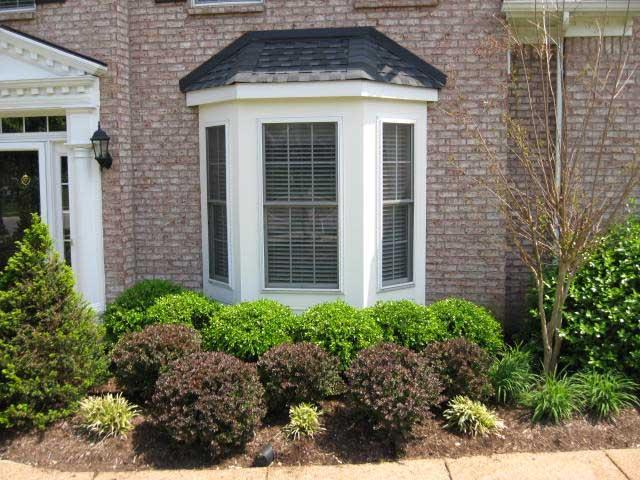

In [21]:
from IPython.display import Image
Image('../data/samples/OST_013.png')

### Intermediate helper (segmentation map)

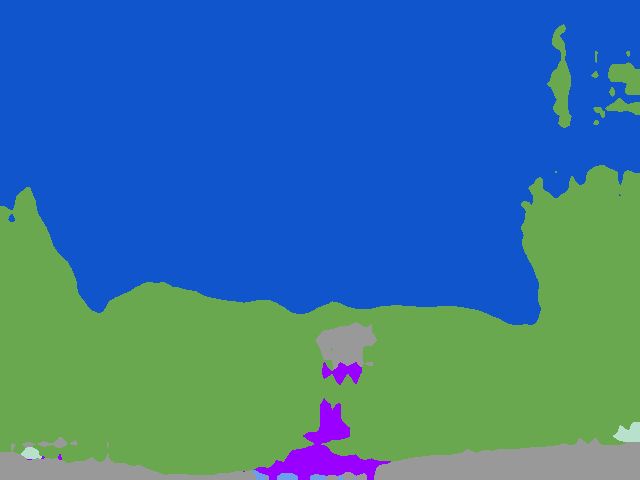

In [22]:
from IPython.display import Image
Image('../data/samples_colorimg/OST_013.png')

### Produced super resolution image

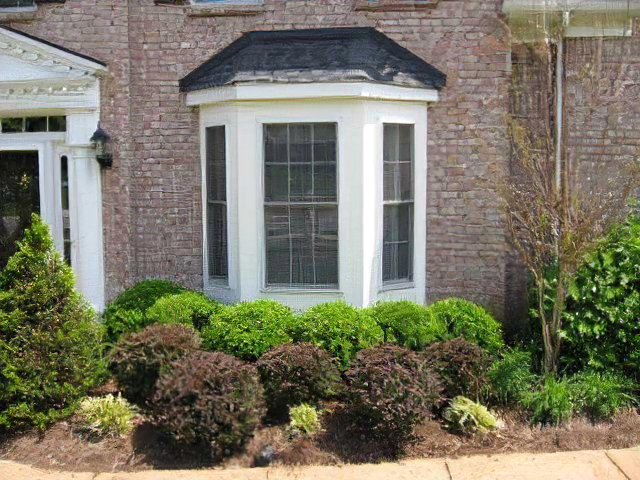

In [25]:
from IPython.display import Image
Image('../data/samples_result/OST_013_rlt.png')

# PS I must admit that the sample doesn't look all that great ...

## Demo on my own images:

### Original resolution:

In [26]:
!ls ../data/myimages

image_0037.jpg	image_0052.jpg	image_0321.jpg	image_0534.jpg	image_1877.jpg


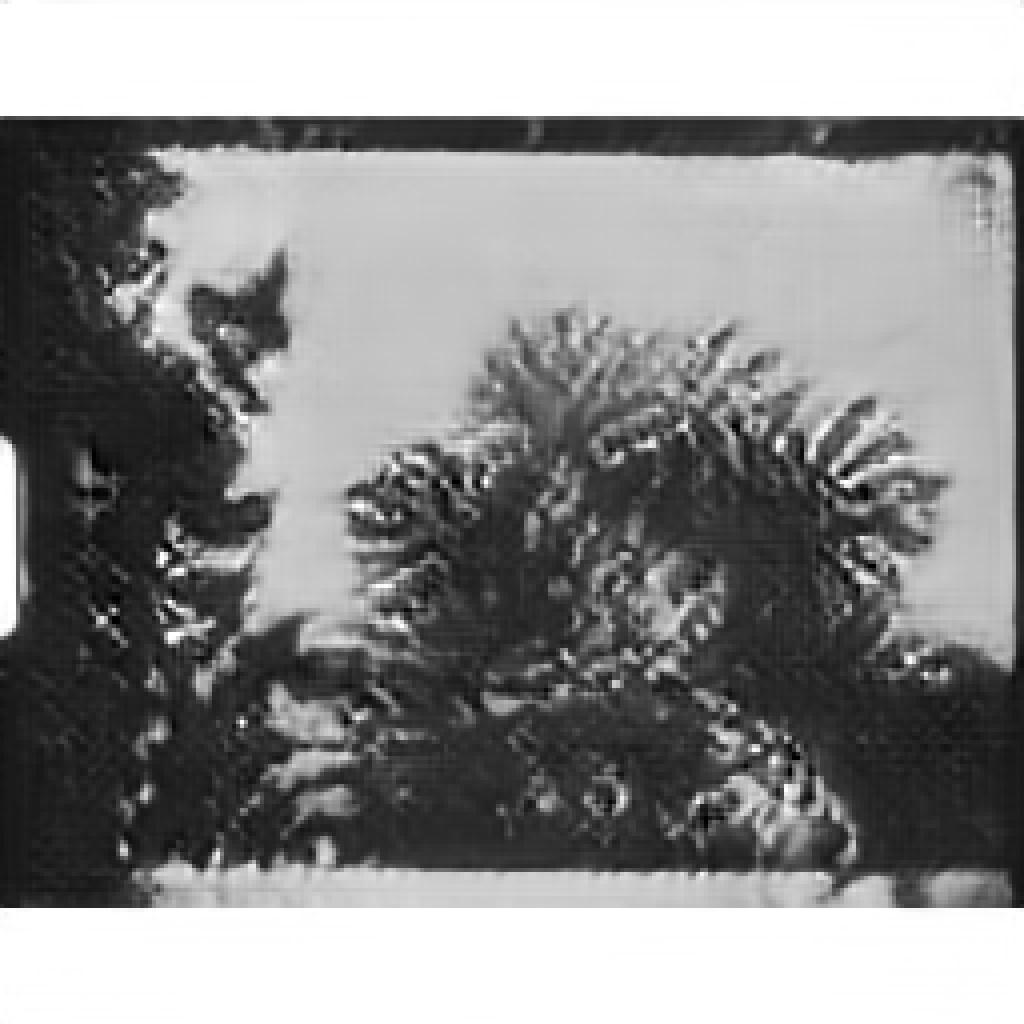

In [27]:
from IPython.display import Image
Image('../data/myimages/image_0052.jpg')

### Intermediate helper (segmentation map)

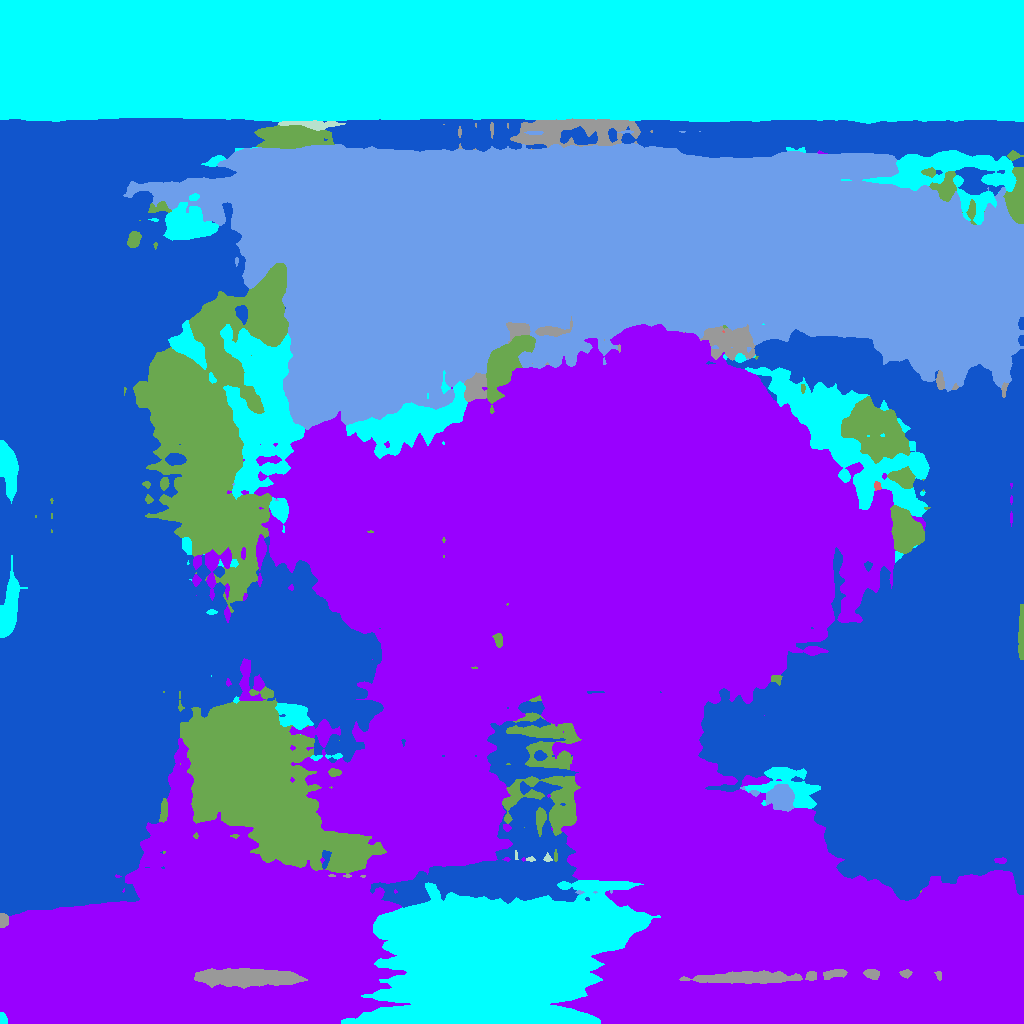

In [28]:
from IPython.display import Image
Image('../data/myimages_colorimg/image_0052.png')

### Produced super resolution image

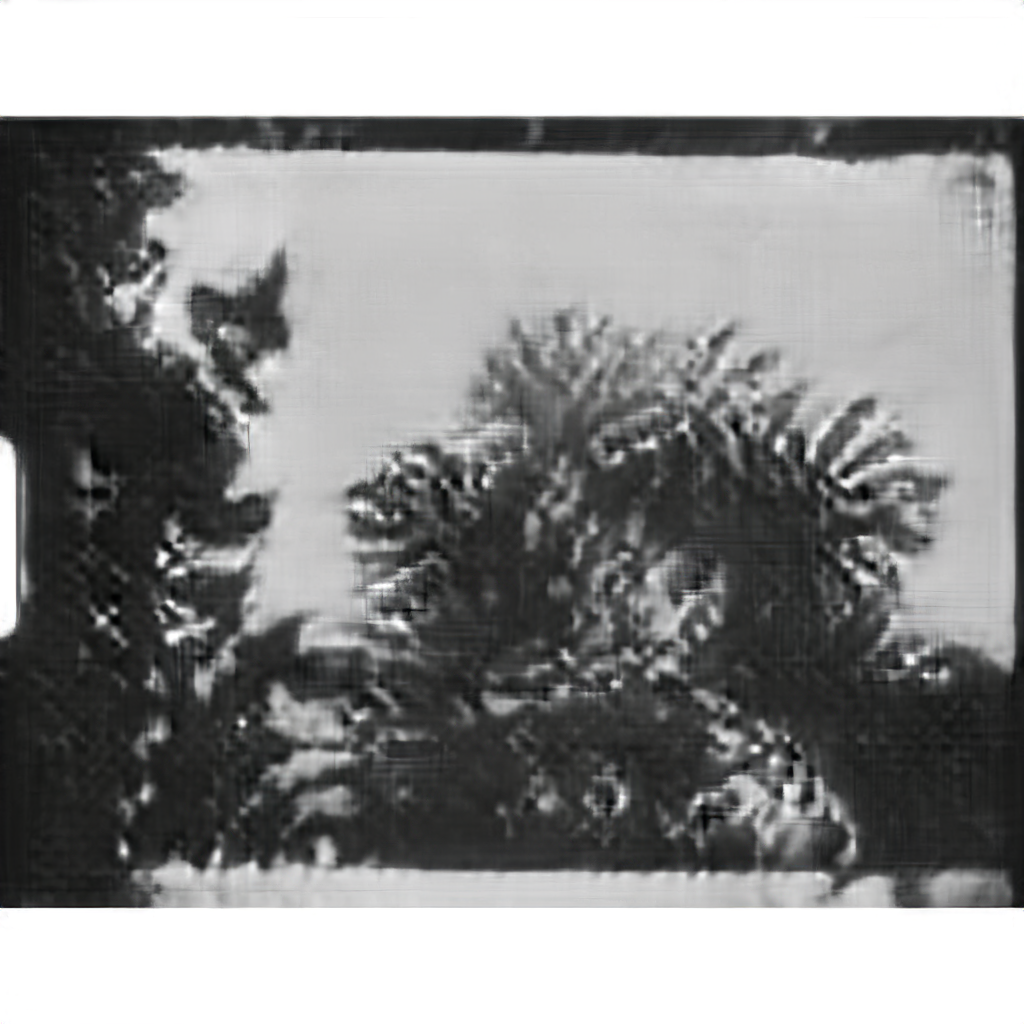

In [29]:
from IPython.display import Image
Image('../data/myimages_result/image_0052_rlt.png')

# For my own pretty low res data (1024x1024 generated image), it looks like this:
# (not perfect, but pretty good!)